In [1]:
import os
import pickle
import glob
from os.path import join as pjoin
import glob
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
#from numpy.linalg import norm as lnorm
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
sns.set_context('notebook')
sns.set_style('ticks')

# Lihui's behavioral data

Inspect one of the subject's results for better understanding.

In [3]:
datadir = './Lihui_Data/RI/Exp2'

In [4]:
test_data = pd.read_hdf(pjoin(datadir, 'sub-001_ver1_sess1_Naming.hdf'))
test_data.head()

,Img,ImgName,AlterNames,Answer,Choice,RT,MousePos,Block,Trlnum
0,stim_set/Loeffel.6_v2_percept.png,Löffel,"[Schere, Zahnpasta, Glas]",0,3,2.481411,"[-0.4635416666666667, -0.2111111111111111]",0,0
1,stim_set/Glas.3_v2_percept.png,Glas,"[Schere, Tasse, Flasche]",0,99,0.000000,"[-0.39375, -0.24444444444444444]",0,1
2,stim_set/Flasche.2_v2_percept.png,Flasche,"[Tasse, Banane, Schere]",0,99,0.000000,"[-0.5552083333333333, -0.23148148148148148]",0,2
3,stim_set/Flasche.3_v2_percept.png,Flasche,"[Glas, Schere, Apfel]",0,3,2.212549,"[0.5010416666666667, -0.22037037037037038]",0,3
4,stim_set/Schere.2_v2_percept.png,Schere,"[Zahnpasta, Flasche, Glas]",0,3,2.833762,"[-0.22291666666666668, -0.22407407407407406]",0,4


Take the results from the second experiment, naming task.

# Compute Euclidean Distance between original and simulation

In [5]:
def comp_ed(sim_hmax, orig_hmax):
    """
    Read HMAX output files for simulated and original image with pandas.
    Compute Euclidean distance between the two.
    Return dict with ED, as well as file paths.
    """
    # simulated
    sim_df = pd.read_csv(sim_hmax, header=None)
    assert np.shape(sim_df[0]) == (2000,)

    # original
    orig_df = pd.read_csv(orig_hmax, header=None)
    assert np.shape(orig_df[0]) == (2000,)
    
    #print(sim_df[0].values, orig_df[0].values)
    
    # compute correlation distance
    ed = (1-pearsonr(sim_df[0].values, orig_df[0].values)[0]) / 2 #lnorm(sim_df[0]-orig_df[0])
    
    # get path names of pictures
    orig_pname = orig_hmax.replace('.ascii', '').replace('./results/', '')
    sim_pname = sim_hmax.replace('.ascii', '').replace('./results/', '')
    
    # return dict
    ed_dict = {
        'ed' : ed,
        'orig' : orig_pname,
        'sim' : sim_pname
    }
    return ed_dict

In [6]:
# Example

ed_dict = comp_ed(sim_hmax='./results/Apfel.1_v2_percept.png.ascii',
             orig_hmax='./results/Apfel.1_v1_new.jpg.ascii')

print(ed_dict)

{'ed': 0.015308654611490169, 'sim': 'Apfel.1_v2_percept.png', 'orig': 'Apfel.1_v1_new.jpg'}


## Collect EDs for all relevant stimuli

In [7]:
# how many HMAX outputs have we?
# Should be 144 (80 originals + 64 simulations used by Lihui)
assert len(glob.glob('./results/*')) == 144

In [8]:
# My HMAX output
sim_flist = glob.glob('./results/*')
sim_flist.sort()
# sim_flist

In [9]:
# Names of Lihui's stimuli without file extension
picnames = [pathname.split('/')[-1].replace('_v2_percept.png','') for pathname in test_data.Img.unique()]
#picnames

In [10]:
# iterate through all relevant stimuli

# list of dicts to be filled
ed_dicts = []

for picname in picnames:
    # paths to hmax results
    orig_hmax = './results/' + picname + '_v1_new.jpg.ascii'
    sim_hmax = './results/' + picname + '_v2_percept.png.ascii'
    # ed
    ed_dict = comp_ed(sim_hmax, orig_hmax)
    ed_dicts.append(ed_dict)

assert len(ed_dicts) == 64

## Descriptive statistics

In [11]:
# only the distances
eds = [ed_dict['ed'] for ed_dict in ed_dicts]

In [12]:
print('mean ED: %f' % np.mean(eds))
print('standard deviation: %f' % np.std(eds))

mean ED: 0.028466
standard deviation: 0.008576


/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Count')

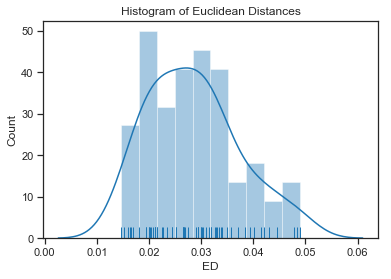

In [13]:
sns.distplot(eds, rug=True, bins=10)

plt.title('Histogram of Euclidean Distances')
plt.xlabel('ED')
plt.ylabel('Count')

**Note:**
- Euclidean distances are not normally distributed due to some outliers with low values (these could be apples)
- Besides that, there seems to be enough variability in the EDs to use for prediction

## Find the outliers

In [14]:
sorted_ed_dicts = sorted(ed_dicts, key=lambda k: k['ed']) 

In [15]:
sorted_ed_dicts[:5]

[{'ed': 0.014565792113087284,
  'orig': 'Apfel.7_v1_new.jpg',
  'sim': 'Apfel.7_v2_percept.png'},
 {'ed': 0.015308654611490169,
  'orig': 'Apfel.1_v1_new.jpg',
  'sim': 'Apfel.1_v2_percept.png'},
 {'ed': 0.015964267331531057,
  'orig': 'Tasse.1_v1_new.jpg',
  'sim': 'Tasse.1_v2_percept.png'},
 {'ed': 0.016376783104483483,
  'orig': 'Tasse.4_v1_new.jpg',
  'sim': 'Tasse.4_v2_percept.png'},
 {'ed': 0.016468820707857157,
  'orig': 'Apfel.2_v1_new.jpg',
  'sim': 'Apfel.2_v2_percept.png'}]

The three outliers are indeed some of the apples.

# Add ED to behavioral data
(as well as subject number)

We want to start with the results from experiment 2, naming task only, which are represented in hdf files.

In [16]:
# Show content of data directory

#sorted(glob.glob(datadir+'/*_ver1*'))

# There's 32 subjects (subject 9 is missing).
# Each has 2 files: one for naming and one for discrimination task.

In [17]:
# Get list of file names for naming task only
hdf_files = sorted(glob.glob(datadir+'/*Naming*'))
assert len(hdf_files) == 32

In [18]:
# Read all files in pandas
behav_dfs = []
for hdf_file in hdf_files:
    behav_df = pd.read_hdf(hdf_file)
    if 'ver1' in hdf_file:
        behav_df['task_order'] = 'ver1'
    elif 'ver2' in hdf_file:
        behav_df['task_order'] = 'ver2'
    behav_dfs.append(behav_df)

#behav_dfs = [pd.read_hdf(hdf_file) for hdf_file in hdf_files]

In [19]:
def insert_eds(df, ed_dicts):
    """
    Insert euclidean distances into a Data Frame.
    """
    # construct new list of euclidean distance, the order of which corresponds
    # to the order they should be inserted in the df
    df_eds = []
    for df_img in df.Img:
        for ed_dict in ed_dicts:
            if ed_dict['sim'] in df_img:
                df_eds.append(ed_dict['ed'])

    assert len(df_eds) == len(df)
    df['ED'] = df_eds
    return df
    # TODO: find more efficient way than nested loop.

In [20]:
dfs = [insert_eds(behav_df, ed_dicts) for behav_df in behav_dfs]

In [21]:
# Add subject number to each df
for df, sub_num in zip(dfs, range(1,len(dfs)+1)):
    df['sub'] = sub_num

In [22]:
# inspect example
dfs[10].head()

,Img,ImgName,AlterNames,Answer,Choice,RT,MousePos,Block,Trlnum,task_order,ED,sub
0,stim_set/Banane.2_v2_percept.png,Banane,"[Löffel, Tasse, Glas]",0,99,0.000000,"[-0.4239583333333333, -0.21481481481481482]",0,0,ver1,0.021112,11
1,stim_set/Glas.1_v2_percept.png,Glas,"[Zahnpasta, Banane, Apfel]",1,0,1.715044,"[0.12083333333333333, -0.23333333333333334]",0,1,ver1,0.040100,11
2,stim_set/Schere.1_v2_percept.png,Schere,"[Löffel, Banane, Zahnpasta]",0,3,2.019426,"[-0.39375, -0.2222222222222222]",0,2,ver1,0.031945,11
3,stim_set/Zahnpasta.5_v2_percept.png,Zahnpasta,"[Tasse, Löffel, Flasche]",0,2,1.912589,"[-0.43020833333333336, -0.24074074074074073]",0,3,ver1,0.025146,11
4,stim_set/Tasse.8_v2_percept.png,Tasse,"[Zahnpasta, Glas, Löffel]",1,0,2.509649,"[0.12083333333333333, -0.23703703703703705]",0,4,ver1,0.016988,11


# Compute centroids

We're only interested in the distance of simulated images from their centroids (for now).

In [23]:
# file names of simulated images
sim_pnames = ['./results/' + picname + '_v2_percept.png.ascii' for picname in picnames]

In [24]:
# Collect HMAX vectors of simulated images
sim_vecs = []
for sim_pname in sim_pnames:
    sim_df = pd.read_csv(sim_pname, header=None)
    sim_vecs.append(sim_df[0].values)
    
# stack result into arrays
sim_arr = np.array(sim_vecs)
# compute centroids
sim_centroid = np.mean(sim_arr, axis=0)

## Compute distance from centroid for every stimulus

In [25]:
# Compute distances from centroid (cd)

 # We'll need to iterate through filenames again to know which CD belongs to which stimulus

cd_dicts = []

for sim_pname in sim_pnames: 
    sim_df = pd.read_csv(sim_pname, header=None)
    sim_vec = sim_df[0].values
    sim_cd = (1-pearsonr(sim_vec, sim_centroid)[0]) / 2 #lnorm(sim_vec-sim_centroid)
    sim_dict = {
        'sim' : sim_pname,
        'cd' : sim_cd
    }
    cd_dicts.append(sim_dict)

# The result is a list of dicts containing file names and CD for simulated images

## Centroid distance histogram

In [26]:
# list of centroid distances
cds = [cd_dict['cd'] for cd_dict in cd_dicts]

Text(0,0.5,'Count')

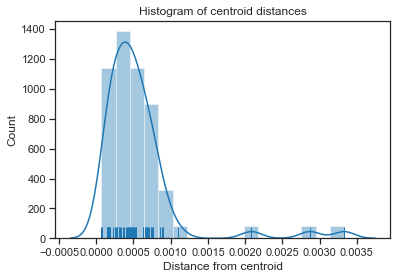

In [27]:
sns.distplot(cds, rug=True)

plt.title('Histogram of centroid distances')
plt.xlabel('Distance from centroid')
plt.ylabel('Count')

In [28]:
# Find outliers
sorted_cd_dicts = sorted(cd_dicts, key=lambda k: k['cd']) 
sorted_cd_dicts[-5:]

[{'cd': 0.0009015391397435013, 'sim': './results/Glas.3_v2_percept.png.ascii'},
 {'cd': 0.00109311562558162, 'sim': './results/Schere.6_v2_percept.png.ascii'},
 {'cd': 0.002085265165460204, 'sim': './results/Apfel.1_v2_percept.png.ascii'},
 {'cd': 0.002869581256188747, 'sim': './results/Apfel.2_v2_percept.png.ascii'},
 {'cd': 0.0033290619197320903,
  'sim': './results/Apfel.3_v2_percept.png.ascii'}]

Again, the three outliers are three of the apples.

## Add CD values to data frames

we will define a general function here and add them to the discrimination task data further below

In [29]:
def insert_cds(df, ed_dicts):
    """
    Insert centroid distances into a Data Frame.
    """
    # construct new list of euclidean distance, the order of which corresponds
    # to the order they should be inserted in the df
    df_cds = []
    for img in df.Img:
        for cd_dict in cd_dicts:
            if cd_dict['sim'].split('/')[-1].replace('.ascii', '') in img:
                df_cds.append(cd_dict['cd'])

    assert len(df_cds) == len(df)
    df['CD'] = df_cds
    return df

In [30]:
dfs = [insert_cds(df, cd_dicts) for df in dfs]

In [31]:
# grab category names from first behavioral data frame
# we can later find the category name in the behavioral data frames again under:
# np.unique(behav_df.ImgName.values)

In [32]:
# list of hmax output files for the original images
# (we already got those for the simulated ones above, under sim_flist)
orig_flist = ['./results/' + picname + '_v1_new.jpg.ascii' for picname in picnames]

In [33]:
pattern_dicts = []

# for the simulated files
for hmax_file in glob.glob('./results/*'):
    # get hmax output vector
    hmax_df = pd.read_csv(hmax_file, header=None)
    pattern = hmax_df.values
    assert len(pattern) == 2000
    # get category and stimulus name
    stimname = hmax_file.split('/')[-1].split('_')[0]
    catname = stimname.split('.')[0]
    # is this an ri percept or original image?
    if '_v1_new.jpg.ascii' in hmax_file:
        vision = 'ri_percept'
    else:
        vision= 'normal'
    # save to dict
    pattern_dict = {
        'pattern' : pattern,
        'category' : catname,
        'stim' : stimname,
        'vision' : vision,
        'filename' : hmax_file
    }
    pattern_dicts.append(pattern_dict)

In [34]:
pattern_dicts[-3]

{'category': 'Uhr',
 'filename': './results/Uhr_v1_new.jpg.ascii',
 'pattern': array([[0.78524779],
        [0.86718308],
        [0.90540196],
        ...,
        [0.98758855],
        [0.98407622],
        [0.98221416]]),
 'stim': 'Uhr',
 'vision': 'ri_percept'}

# Explorative plotting ED

## Reaction times and ED

For exploration, we want to plot the correlation between ED and RT seperately for each block.

- We will start with an example subject
- We can do the same for all subjects at once, treating each datapoint equally and ignoring inter-subject variability. This is only for exploration and does **not** allow statistical inference.

### Example subject

In [35]:
# take first subject as example
test_df = dfs[0]

In [36]:
# Subjects' non-responses yield an RT value of 0 and Choice value of 99.
# Exclude them here.
# However, this will become important later for actual statistical inference.

# test_df[test_df['RT']==0]


There are 7 non-response trials


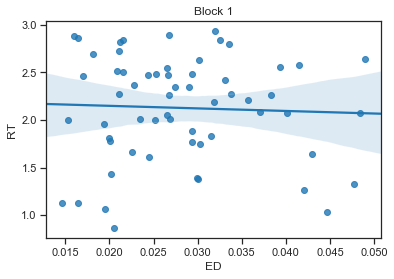

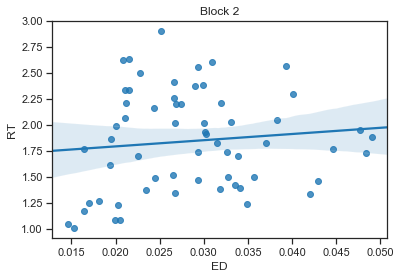

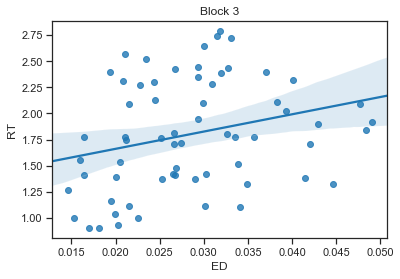

In [37]:
# Count number of non-response trials
print('\nThere are %i non-response trials' % len(test_df[test_df['Choice']==99]))

# Scatter plot the three blocks seperately
for block in xrange(3):
    ax = sns.regplot(x='ED', y='RT',
                     data=test_df[(test_df['Block']==block) & (test_df['Choice']!=99)])
    plt.title('Block %i' % (block+1))
    plt.show()

**Conclusion for example subject**
- This does not tell us much. If anything, it contradicts our intuition that ED should correlate more strongly with RT in the first Block than the other two.

- In general, the slope of the linear fit seems to be driven by the three outliers (i.e. the apples).

### All subjects

In [38]:
# concatinate dfs
df_concat = pd.concat(dfs)

# add task variable
df_concat['task'] = 'name'

In [39]:
# Validate

# the length
assert len(df_concat) == len(dfs[0]) * 32
# all subjects are there
np.unique(df_concat['sub'].values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

**Scatter plot RT and ED for the three blocks just as before**


There are 414 non-response trials


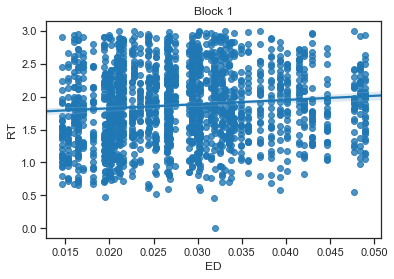

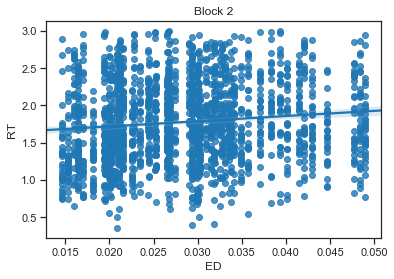

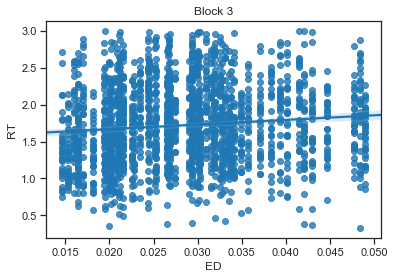

In [40]:
print('\nThere are %i non-response trials' % len(df_concat[df_concat['Choice']==99]))

for block in xrange(3):
    ax = sns.regplot(x='ED', y='RT',
                     data=df_concat[(df_concat['Block']==block) & (df_concat['Choice']!=99)])
    plt.title('Block %i' % (block+1))
    plt.show()

**Conclusions from explorative correlations with RT:**

There seems to be *no correlation* between ED and RT in any of the blocks when outliers are removed. This makes it unlikely that a prediction of RT by HMAX difference would be successfull.

However, These correlations do not inform the potential *learning*, which would reflect in changes of RT / accuracy across the experiment. This could only be investigated with a real *statistical model*, such as LMM, regression, ANCOVA, or others.

## Accuracy and ED

### (Logistic) regression plot

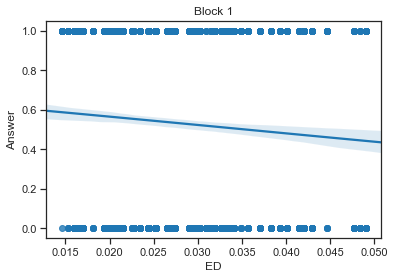

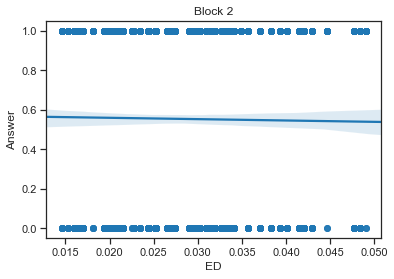

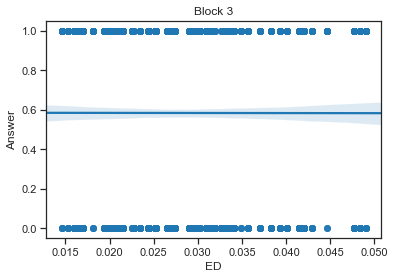

In [41]:
for block in range(3):
    sns.regplot(y='Answer', x='ED',
                data=df_concat[ (df_concat['Choice'] != 99)
                               #& (df_concat['ED'] > 10)
                               & (df_concat['Block'] == block)],
                logistic=True, n_boot=200)
    plt.title('Block %i' % (block+1))
    plt.show()

**Conclusions explorative Accuracy analysis:**

Much like with reaction times, there does not seem to be much of a statistical relationship between HMAX difference and accuracies. The same reasoning holds that an iference analysis could yield an interaction between time (i.e. block) and ED, which would signal learning depends on loss of visual information. **The question is if this would be worth it.** Right now, it doesn't look very promising.

# Discrimination task

## Stimuli and Design of Experiment 2

Stimuli and design in Experiment 2 were the same as in Experiment 1 except that there were always 4 alternative choices across all blocks, and the time limit for accepting response was 3s. There was an additional post-test which took place one week later. The post-test consisted of a block of the naming task, and a block of the discrimination task, which was the same as the task during training. The order of the two blocks in the post-test was fixed in the way that the first block was always the same as the last block during training.

**Sidenote**: *Above chance accuracies (ACA)* were the main measure of performance in Lihui's analysis. There, she subtracted the chance level  (which depended on the number of distractors) from the average accuracy in each block. If we want to set up a trial-wise model, we cannot do that.

## Load discrimination task data

And add ED, subject number, as well as ACA

In [42]:
# sorted list of hdf files
disc_files = sorted(glob.glob(datadir+'/*Discrimination*'))
assert len(disc_files) == 32

# Read all files in pandas and add task order from filename
disc_dfs = []
for disc_file in disc_files:
    disc_df = pd.read_hdf(disc_file)
    if 'ver1' in disc_file:
        disc_df['task_order'] = 'ver1'
    elif 'ver2' in disc_file:
        disc_df['task_order'] = 'ver2'
    disc_dfs.append(disc_df)

# insert EDs and CDs
disc_dfs = [insert_eds(df, ed_dicts) for df in disc_dfs]
disc_dfs = [insert_cds(df, cd_dicts) for df in disc_dfs]

# iterate through dfs
for df, sub_num in zip(disc_dfs, range(1,len(disc_dfs)+1)):
    
    # add subject number
    df['sub'] = sub_num

    # compute and insert ACA
    for block in range(3):
        df.loc[df['Block'] == block,'ACA'] = (np.mean(df.loc[df['Block'] == block, 'Answer']) - .25)
    
# concatinate into one data frame
disc_df = pd.concat(disc_dfs)

# add task variable
disc_df['task'] = 'disc'

In [43]:
disc_df.head()

,Img,ImgName,AlterImgs,Answer,Choice,RT,MousePos,Block,Trlnum,task_order,ED,CD,sub,ACA,task
0,stim_set/Flasche.1_v2_percept.png,Flasche,"[stim_set/Schere.3_v2_percept.png, stim_set/Lo...",1,0,1.762020,"[-0.55625, -0.17222222222222222]",0,0,ver1,0.021108,0.000281,1,0.484375,disc
1,stim_set/Zahnpasta.7_v2_percept.png,Zahnpasta,"[stim_set/Banane.1_v2_percept.png, stim_set/Gl...",0,99,0.000000,"[0.14479166666666668, -0.21481481481481482]",0,1,ver1,0.041507,0.000626,1,0.484375,disc
2,stim_set/Banane.1_v2_percept.png,Banane,"[stim_set/Schere.4_v2_percept.png, stim_set/Ta...",0,1,1.705525,"[0.28958333333333336, -0.06851851851851852]",0,2,ver1,0.026789,0.000160,1,0.484375,disc
3,stim_set/Loeffel.8_v2_percept.png,Löffel,"[stim_set/Banane.2_v2_percept.png, stim_set/Ta...",1,0,1.595861,"[-0.17708333333333334, -0.2833333333333333]",0,3,ver1,0.033839,0.000449,1,0.484375,disc
4,stim_set/Loeffel.2_v2_percept.png,Löffel,"[stim_set/Apfel.8_v2_percept.png, stim_set/Ban...",1,0,1.622645,"[0.2125, -0.1685185185185185]",0,4,ver1,0.042057,0.000694,1,0.484375,disc


In [44]:
# add unique item identifier
unique_images = sorted(np.unique(disc_df.Img.values))

for img, item_id in zip(unique_images, range(len(unique_images))):
    disc_df.loc[disc_df['Img'] == img,'item_id'] = item_id

# make item identifier categorical
disc_df['item_id'] = disc_df['item_id'].astype('str')

In [45]:
disc_df.head()

,Img,ImgName,AlterImgs,Answer,Choice,RT,MousePos,Block,Trlnum,task_order,ED,CD,sub,ACA,task,item_id
0,stim_set/Flasche.1_v2_percept.png,Flasche,"[stim_set/Schere.3_v2_percept.png, stim_set/Lo...",1,0,1.762020,"[-0.55625, -0.17222222222222222]",0,0,ver1,0.021108,0.000281,1,0.484375,disc,16.0
1,stim_set/Zahnpasta.7_v2_percept.png,Zahnpasta,"[stim_set/Banane.1_v2_percept.png, stim_set/Gl...",0,99,0.000000,"[0.14479166666666668, -0.21481481481481482]",0,1,ver1,0.041507,0.000626,1,0.484375,disc,62.0
2,stim_set/Banane.1_v2_percept.png,Banane,"[stim_set/Schere.4_v2_percept.png, stim_set/Ta...",0,1,1.705525,"[0.28958333333333336, -0.06851851851851852]",0,2,ver1,0.026789,0.000160,1,0.484375,disc,8.0
3,stim_set/Loeffel.8_v2_percept.png,Löffel,"[stim_set/Banane.2_v2_percept.png, stim_set/Ta...",1,0,1.595861,"[-0.17708333333333334, -0.2833333333333333]",0,3,ver1,0.033839,0.000449,1,0.484375,disc,39.0
4,stim_set/Loeffel.2_v2_percept.png,Löffel,"[stim_set/Apfel.8_v2_percept.png, stim_set/Ban...",1,0,1.622645,"[0.2125, -0.1685185185185185]",0,4,ver1,0.042057,0.000694,1,0.484375,disc,33.0


## Are ED and CD correlated?

In [46]:
# Sort both cd and ed list of dicts by stimulus, so we can compare.
cd_dicts_bystim = sorted(cd_dicts, key=lambda k: k['sim'])
ed_dicts_bystim = sorted(ed_dicts, key=lambda k: k['sim'])

In [47]:
# make sure it's correct
assert len(cd_dicts_bystim) == 64 & len(ed_dicts_bystim) == 64
for cd_dict, ed_dict in zip(cd_dicts, ed_dicts):
    assert ed_dict['sim'] in cd_dict['sim']

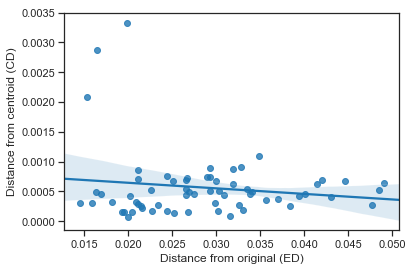

Correlation between ED and CD (with outliers): -0.146


In [48]:
sns.regplot(x=[ed_dict['ed'] for ed_dict in ed_dicts_bystim],
            y=[cd_dict['cd'] for cd_dict in cd_dicts_bystim])
plt.xlabel('Distance from original (ED)')
plt.ylabel('Distance from centroid (CD)')
plt.show()

corr = np.corrcoef(x=[ed_dict['ed'] for ed_dict in ed_dicts_bystim],
                   y=[cd_dict['cd'] for cd_dict in cd_dicts_bystim])[0][1]

print('Correlation between ED and CD (with outliers): %.3f' % corr)

**Conclusion:**
- If we leave in the apples, there is a negative correlation between ED and CD.
- However, the plot suggests that if we cut the apples, the correlation is actually positive.

### Exclude apples

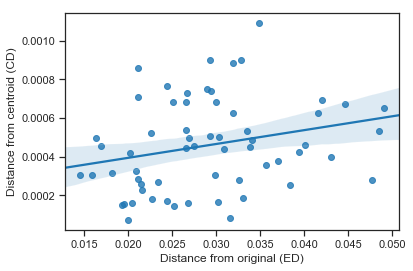

Correlation between ED and CD (outliers removed): 0.256


In [49]:
# we know the outliers are the lowest 3 values

# define new variables, else it gets too cluttered
ed_x = [ed_dict['ed'] for ed_dict in ed_dicts_bystim[3:]]
cd_y = [cd_dict['cd'] for cd_dict in cd_dicts_bystim[3:]]

sns.regplot(x=ed_x, y=cd_y)
plt.xlabel('Distance from original (ED)')
plt.ylabel('Distance from centroid (CD)')
plt.show()

corr = np.corrcoef(x=ed_x, y=cd_y)[0][1]

print('Correlation between ED and CD (outliers removed): %.3f' % corr)

**Conclusions:**
- So if we remove the apples, the correlation between ED and CD is actually positive and substantial.
- Yet, The two measures may still contain independent information which both can be considered for modelling.

## ACAs per block

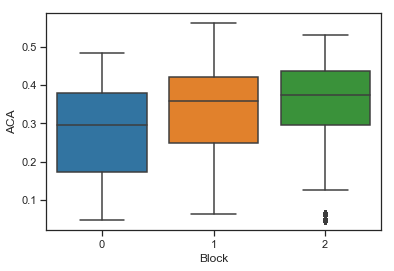

In [50]:
sns.boxplot(data=disc_df, x='Block', y='ACA')

## Logistic plot for Accuracy by ED for each block

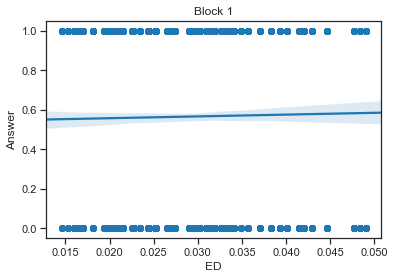

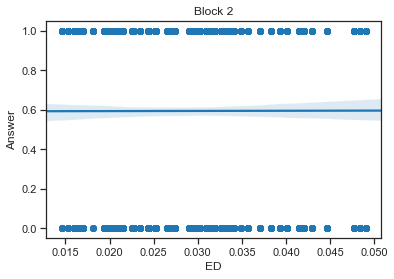

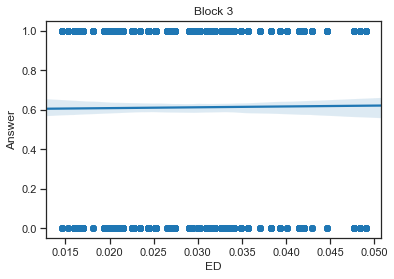

In [51]:
for block in range(3):
    sns.regplot(y='Answer', x='ED',
                data=disc_df[ (disc_df['Choice'] != 99)
                               #& (disc_df['ED'] > 10)
                               & (disc_df['Block'] == block)],
                logistic=True, n_boot=200)
    plt.title('Block %i' % (block+1))
    plt.show()

## Reaction times by ED and block

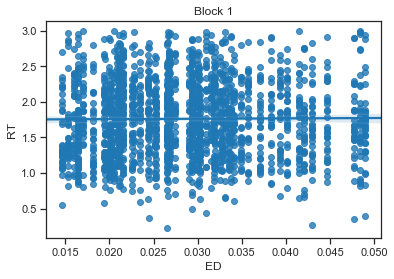

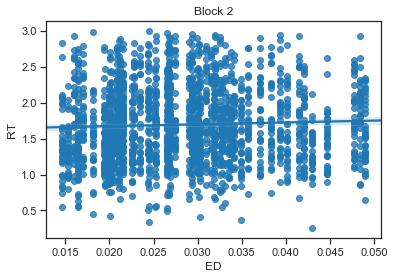

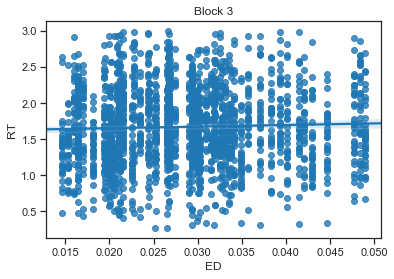

In [52]:
for block in xrange(3):
    ax = sns.regplot(x='ED', y='RT',
                     data=disc_df[(
                         disc_df['Block']==block) & (disc_df['Choice']!=99)# & (disc_df['ED'] > 10)
                                   ])
    plt.title('Block %i' % (block+1))
    plt.show()

# Add Neural Typicality to discrimination task data

In [53]:
# load pickle
nt_df = pickle.load(open('nt_df.p', 'rb'))

In [54]:
# create new column to match with behavioral dfs
nt_df['Img'] = pd.Series(['stim_set/' + filename.replace('.ascii', '') for filename in nt_df.filename.values])
#nt_df.head()

In [55]:
# merge dataframes for neural typicality and discrimination task data
disc_df = pd.merge(disc_df, nt_df, on=['Img'])
assert len(np.unique(disc_df.newNT.values)) == 64

In [56]:
disc_df.head()

,Img,ImgName,AlterImgs,Answer,Choice,RT,MousePos,Block,Trlnum,task_order,...,filename,stim,vision,newNT,newNT_cent,conNT,conNT_cent,pattern,newNT_z,conNT_z
0,stim_set/Flasche.1_v2_percept.png,Flasche,"[stim_set/Schere.3_v2_percept.png, stim_set/Lo...",1,0,1.762020,"[-0.55625, -0.17222222222222222]",0,0,ver1,...,Flasche.1_v2_percept.png.ascii,Flasche.1,ri_percept,6.996014,0.002537,8.711341,-0.029455,"[0.3888220176246661, 0.4689675547636402, 0.518...",0.680759,-0.524276
1,stim_set/Flasche.1_v2_percept.png,Flasche,"[stim_set/Banane.2_v2_percept.png, stim_set/Ta...",0,1,2.242939,"[0.2760416666666667, -0.22962962962962963]",1,33,ver1,...,Flasche.1_v2_percept.png.ascii,Flasche.1,ri_percept,6.996014,0.002537,8.711341,-0.029455,"[0.3888220176246661, 0.4689675547636402, 0.518...",0.680759,-0.524276
2,stim_set/Flasche.1_v2_percept.png,Flasche,"[stim_set/Zahnpasta.5_v2_percept.png, stim_set...",1,0,1.766368,"[0.653125, -0.18518518518518517]",2,39,ver1,...,Flasche.1_v2_percept.png.ascii,Flasche.1,ri_percept,6.996014,0.002537,8.711341,-0.029455,"[0.3888220176246661, 0.4689675547636402, 0.518...",0.680759,-0.524276
3,stim_set/Flasche.1_v2_percept.png,Flasche,"[stim_set/Banane.4_v2_percept.png, stim_set/Gl...",1,0,2.559490,"[-0.109375, -0.17592592592592593]",0,38,ver1,...,Flasche.1_v2_percept.png.ascii,Flasche.1,ri_percept,6.996014,0.002537,8.711341,-0.029455,"[0.3888220176246661, 0.4689675547636402, 0.518...",0.680759,-0.524276
4,stim_set/Flasche.1_v2_percept.png,Flasche,"[stim_set/Schere.7_v2_percept.png, stim_set/Ta...",0,99,0.000000,"[0.0125, -0.5314814814814814]",1,44,ver1,...,Flasche.1_v2_percept.png.ascii,Flasche.1,ri_percept,6.996014,0.002537,8.711341,-0.029455,"[0.3888220176246661, 0.4689675547636402, 0.518...",0.680759,-0.524276


# Logistic LME on accuracies (with R)

In [57]:
# Load rpy
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

## install R packages with conda

needs to be done in terminal, because console expects input (y/n)

- essential packages: *conda install -c r r-essentials*

- individual packages: *conda install -c r r-lme4*

In [58]:
%%R

library(lme4)
#library(tidyverse)
library(ggplot2)
library(multcomp)
library(brms)

/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Lade nötiges Paket: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Lade nötiges Paket: mvtnorm

  warnings.warn(x, RRuntimeWarning)
/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Lade nötiges Paket: survival

  warnings.warn(x, RRuntimeWarning)
/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Lade nötiges Paket: TH.data

  warnings.warn(x, RRuntimeWarning)
/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Lade nötiges Paket: MASS

  warnings.warn(x, RRuntimeWarning)
/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186:

## Prepare padas df and import in R

In [59]:
# Remove non-response trials from data frame
disc_df_r = disc_df[disc_df.Choice!=99]

# drop irrelevant columns from pandas df to avoid rpy2 import error
dropcols = ['Img', 'ImgName', 'AlterImgs', 'MousePos', 'ACA', 'pattern']
disc_df_r = disc_df_r.drop(columns=dropcols)

# Convert variables to string which should be treated as catigorical by R
for col in ['sub', 'Answer', 'Block']:
    disc_df_r[col] = disc_df_r[col].astype('str')

In [60]:
%%R -i disc_df_r
# Load data frame into R

# Make Block an ordered factor, since we are interested in a linear change across time.
disc_df_r$Block <- factor(disc_df_r$Block, ordered=FALSE)

# Show structure of imported data frame
str(disc_df_r)

'data.frame':	5953 obs. of  21 variables:
 $ Answer    : Factor w/ 2 levels "0","1": 2 1 2 2 2 1 1 2 2 2 ...
 $ Choice    : int  0 1 0 0 0 1 2 0 0 0 ...
 $ RT        : num  1.76 2.24 1.77 2.56 2.42 ...
 $ Block     : Factor w/ 3 levels "0","1","2": 1 2 3 1 3 1 2 3 1 2 ...
 $ Trlnum    : int  0 33 39 38 51 2 51 46 31 6 ...
 $ task_order: Factor w/ 2 levels "ver1","ver2": 1 1 1 1 1 2 2 2 2 2 ...
 $ ED        : num  0.0211 0.0211 0.0211 0.0211 0.0211 ...
 $ CD        : num  0.000281 0.000281 0.000281 0.000281 0.000281 ...
 $ sub       : Factor w/ 32 levels "1","10","11",..: 1 1 1 12 12 23 23 23 27 27 ...
 $ task      : Factor w/ 1 level "disc": 1 1 1 1 1 1 1 1 1 1 ...
 $ item_id   : Factor w/ 64 levels "0.0","1.0","10.0",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ category  : Factor w/ 8 levels "Apfel","Banane",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ filename  : Factor w/ 64 levels "Apfel.1_v2_percept.png.ascii",..: 17 17 17 17 17 17 17 17 17 17 ...
 $ stim      : Factor w/ 64 levels "Apfel.1","Apfel.2",..: 17

In [61]:
%%R

# Show data frame head
head(disc_df_r)

  Answer Choice       RT Block Trlnum task_order         ED          CD sub
0      1      0 1.762020     0      0       ver1 0.02110831 0.000281395   1
1      0      1 2.242939     1     33       ver1 0.02110831 0.000281395   1
2      1      0 1.766368     2     39       ver1 0.02110831 0.000281395   1
3      1      0 2.559490     0     38       ver1 0.02110831 0.000281395   2
5      1      0 2.417423     2     51       ver1 0.02110831 0.000281395   2
6      0      1 1.718840     0      2       ver2 0.02110831 0.000281395   3
  task item_id category                       filename      stim     vision
0 disc    16.0  Flasche Flasche.1_v2_percept.png.ascii Flasche.1 ri_percept
1 disc    16.0  Flasche Flasche.1_v2_percept.png.ascii Flasche.1 ri_percept
2 disc    16.0  Flasche Flasche.1_v2_percept.png.ascii Flasche.1 ri_percept
3 disc    16.0  Flasche Flasche.1_v2_percept.png.ascii Flasche.1 ri_percept
5 disc    16.0  Flasche Flasche.1_v2_percept.png.ascii Flasche.1 ri_percept
6 disc    16

# Save RData for modelling outside of this notebook

## Full data frame for discrimination task data: disc_df_brms

In [62]:
%%R

# BRMS requires the response to be numeric for binomial models

disc_df_brms <- disc_df_r
disc_df_brms$Answer <- as.numeric(disc_df_brms$Answer)
disc_df_brms$Answer <- disc_df_brms$Answer - 1 # for some reason, conversion from factor to numeric produces 1s and 2s
#str(disc_df_brms)

## Slice of discrimination task data: test_df

In [63]:
%%R

# shrink data frame for testing purposes

# choose only sub 1 and 2  for testing
test_df <- disc_df_brms[disc_df_brms$sub==1 | disc_df_brms$sub==2, ] # pipe is the logical OR here.
# Only take the first half of trials
test_df <- test_df[test_df$Trlnum <= 32,]

#str(test_df)

## Combine naming and discrimination task data frames and add task order as variable

###  Prepare naming task df

In [64]:
# pull naming dfs from all subjects into one df
name_df_r = pd.concat(dfs)

# add task name
name_df_r['task'] = 'name'

# only select correct responses
name_df_r = name_df_r[name_df_r.Choice!=99]

In [65]:
# add item_id
unique_images = sorted(np.unique(name_df_r.Img.values))

for img, item_id in zip(unique_images, range(len(unique_images))):
    name_df_r.loc[name_df_r['Img'] == img,'item_id'] = item_id

# make item identifier categorical
name_df_r['item_id'] = name_df_r['item_id'].astype('str')

In [66]:
# merge naming with neural typicality data frame
name_df_r = pd.merge(name_df_r, nt_df, on=['Img'])
assert len(np.unique(name_df_r.newNT.values)) == 64

In [67]:
# drop redundant / difficoult to import columns
dropcols = ['Img', 'ImgName', 'AlterNames', 'MousePos']
name_df_r = name_df_r.drop(columns=dropcols)

### Combine naming and discrimination df

In [68]:
df_total = disc_df_r.append(name_df_r)

/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [69]:
# drop more redundant columns
dropcols = ['filename', 'category', 'pattern', 'vision', 'stim']
df_total = df_total.drop(columns=dropcols)

In [70]:
# make categorical: block, sub, answer
colnames = ['Block', 'sub', 'Answer']
for colname in colnames:
    df_total[colname] = df_total[colname].astype('str')

In [71]:
# assert length
assert len(df_total) == len(disc_df_r) + len(name_df_r)

In [72]:
df_total.head()

,Answer,Block,CD,Choice,ED,RT,Trlnum,conNT,conNT_cent,conNT_z,item_id,newNT,newNT_cent,newNT_z,sub,task,task_order
0,1,0,0.000281,0,0.021108,1.762020,0,8.711341,-0.029455,-0.524276,16.0,6.996014,0.002537,0.680759,1,disc,ver1
1,0,1,0.000281,1,0.021108,2.242939,33,8.711341,-0.029455,-0.524276,16.0,6.996014,0.002537,0.680759,1,disc,ver1
2,1,2,0.000281,0,0.021108,1.766368,39,8.711341,-0.029455,-0.524276,16.0,6.996014,0.002537,0.680759,1,disc,ver1
3,1,0,0.000281,0,0.021108,2.559490,38,8.711341,-0.029455,-0.524276,16.0,6.996014,0.002537,0.680759,2,disc,ver1
5,1,2,0.000281,0,0.021108,2.417423,51,8.711341,-0.029455,-0.524276,16.0,6.996014,0.002537,0.680759,2,disc,ver1


## Effect coding for categorical variables

### block

introduce two new variables (ec_b2 and ec_b3) that code the effect of blocks 2 and 3 against block 1.

In [73]:
for target_block in [2,3]:
    # target_block starts counting at 1, while the previous "Block" column in the df started at 0.
    source_string = str(target_block -1)
    df_total.loc[df_total['Block'] == '0', 'ec_b%s' % target_block] = -1
    df_total.loc[df_total['Block'] == source_string, 'ec_b%s' % target_block] = 1
    df_total.loc[(df_total['Block'] != '0') & (df_total['Block'] != source_string), 'ec_b%s' % target_block] = 0

In [74]:
#df_total.head()

### task

Introduce new variable ec_task that has value 1 for name and -1 for disc task

In [75]:
df_total.loc[df_total['task'] == 'name', 'ec_task'] = 1
df_total.loc[df_total['task'] == 'disc', 'ec_task'] = -1

In [76]:
#df_total.head()

### task order

We didn't add task order before. Let's get that done and also effect code it.

In [77]:
df_total.loc[df_total['task_order'] == 'ver1', 'ec_taskorder'] = 1
df_total.loc[df_total['task_order'] == 'ver2', 'ec_taskorder'] = -1

In [78]:
df_total.head()

,Answer,Block,CD,Choice,ED,RT,Trlnum,conNT,conNT_cent,conNT_z,...,newNT,newNT_cent,newNT_z,sub,task,task_order,ec_b2,ec_b3,ec_task,ec_taskorder
0,1,0,0.000281,0,0.021108,1.762020,0,8.711341,-0.029455,-0.524276,...,6.996014,0.002537,0.680759,1,disc,ver1,-1.0,-1.0,-1.0,1.0
1,0,1,0.000281,1,0.021108,2.242939,33,8.711341,-0.029455,-0.524276,...,6.996014,0.002537,0.680759,1,disc,ver1,1.0,0.0,-1.0,1.0
2,1,2,0.000281,0,0.021108,1.766368,39,8.711341,-0.029455,-0.524276,...,6.996014,0.002537,0.680759,1,disc,ver1,0.0,1.0,-1.0,1.0
3,1,0,0.000281,0,0.021108,2.559490,38,8.711341,-0.029455,-0.524276,...,6.996014,0.002537,0.680759,2,disc,ver1,-1.0,-1.0,-1.0,1.0
5,1,2,0.000281,0,0.021108,2.417423,51,8.711341,-0.029455,-0.524276,...,6.996014,0.002537,0.680759,2,disc,ver1,0.0,1.0,-1.0,1.0


## Save workspace

In [79]:
"""
Take only subject 1 and 2 for testing the model building more quickly.
"""
df_slice = df_total[(df_total['sub']=="1") | (df_total['sub']=="2")]
#df_slice.head()

In [80]:
%%R -i df_total -i df_slice

# show resulting R data.frame
str(df_total)
#str(df_slice)

'data.frame':	11683 obs. of  21 variables:
 $ Answer      : Factor w/ 2 levels "0","1": 2 1 2 2 2 1 1 2 2 2 ...
 $ Block       : Factor w/ 3 levels "0","1","2": 1 2 3 1 3 1 2 3 1 2 ...
 $ CD          : num  0.000281 0.000281 0.000281 0.000281 0.000281 ...
 $ Choice      : int  0 1 0 0 0 1 2 0 0 0 ...
 $ ED          : num  0.0211 0.0211 0.0211 0.0211 0.0211 ...
 $ RT          : num  1.76 2.24 1.77 2.56 2.42 ...
 $ Trlnum      : int  0 33 39 38 51 2 51 46 31 6 ...
 $ conNT       : num  8.71 8.71 8.71 8.71 8.71 ...
 $ conNT_cent  : num  -0.0295 -0.0295 -0.0295 -0.0295 -0.0295 ...
 $ conNT_z     : num  -0.524 -0.524 -0.524 -0.524 -0.524 ...
 $ item_id     : Factor w/ 64 levels "0.0","1.0","10.0",..: 9 9 9 9 9 9 9 9 9 9 ...
 $ newNT       : num  7 7 7 7 7 ...
 $ newNT_cent  : num  0.00254 0.00254 0.00254 0.00254 0.00254 ...
 $ newNT_z     : num  0.681 0.681 0.681 0.681 0.681 ...
 $ sub         : Factor w/ 32 levels "1","10","11",..: 1 1 1 12 12 23 23 23 27 27 ...
 $ task        : Factor w/ 

In [81]:
%%R
# save entire R workspace
save.image(file = "prepped_data.RData", version = NULL, safe = TRUE)

In [82]:
with open('df_total.pickle', 'w') as f:
    pickle.dump(df_total, f)